ECE:5450 Machine Learning
Project Part 1
Ryan McDaniel

High Level Overview:



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import platform
import pickle
import get_data as gd

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'text.color': "white"})
plt.rcParams['figure.figsize'] = [24, 6]
plt.rcParams['axes.facecolor'] = 'black'

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extract Features from Entire Dataset

In [2]:
import get_features as gf
from skimage import color, filters
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler

def extract(data):
    ret = np.zeros((len(data), 5120))

    greys = np.zeros((len(data), 1024))
    fft_sobels = np.zeros((len(data), 1024))
    hogs = np.zeros((len(data), 2048))
    sobels = np.zeros((len(data), 1024))

    for i in range(len(data)):
        original = gf.toImage(data[i])
        grey = color.rgb2grey(original)
        hsv = color.rgb2hsv(original)
        h, s, v = gf.toComps(hsv)

        f_sobels = gf.toFeatures(filters.sobel(v))
        f_grey = gf.toFeatures(grey)
        f_fft_sobel = gf.toFeatures(gf.FFT(s))
        f_hog = hog(grey, orientations=8, pixels_per_cell=(2, 2),
                    cells_per_block=(1, 1), feature_vector = True)

        greys[i] = f_grey
        fft_sobels[i] = f_fft_sobel
        hogs[i] = f_hog
        sobels[i] = f_sobels

    greys = gf.normalize(greys)
    fft_sobels = gf.normalize(fft_sobels)
    hogs = gf.normalize(hogs)
    sobels = gf.normalize(sobels)

    ret = np.concatenate((greys, fft_sobels, hogs, sobels), axis = 1).astype(np.float32)
    ret[np.isnan(ret)] = 0

    return ret

x_train, y_train, x_val, y_val, x_test, y_test = gd.get_CIFAR10_data()

%time x_train_features = extract(x_train)
%time x_val_features = extract(x_val)
%time x_test_features = extract(x_test)

# x_train_features= x_train
# x_val_features  = x_val
# x_test_features = x_test

print(x_train_features.shape)
print(x_val_features.shape)




Validation Set Grid Search

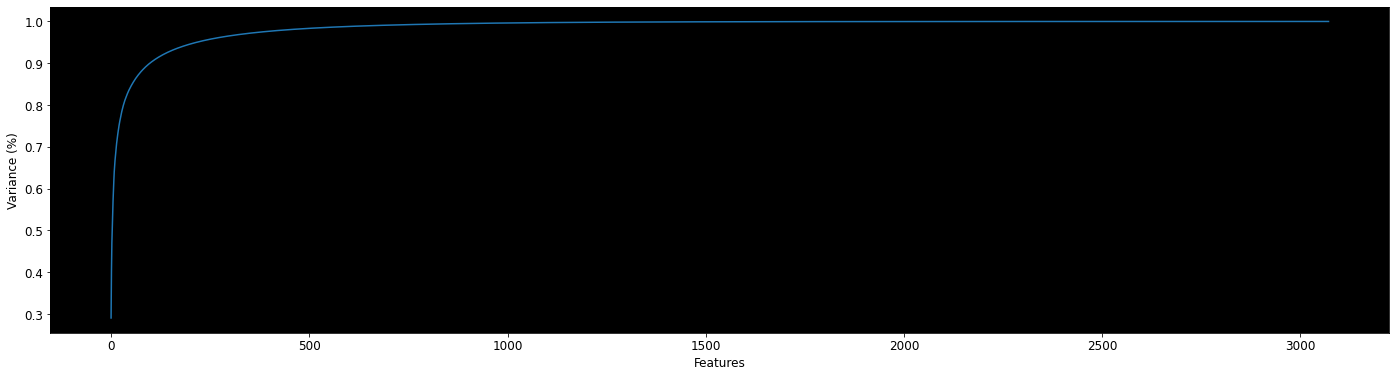

Wall time: 1min 41s
{'svc__C': 10, 'svc__gamma': 0.0001}


In [3]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA().fit(x_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Features')
plt.ylabel('Variance (%)')
plt.show()

pca = RandomizedPCA(n_components=500, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(x_val_features, y_val)
print(grid.best_params_)


Develop Model on Training Data

In [4]:
# Reduce dimension of non validation sets
x_train_PCA = pca.fit_transform(x_train_features)
x_test_PCA = pca.fit_transform(x_test_features)

svc = SVC(kernel='rbf', class_weight='balanced', C = grid.best_params_['svc__C'], gamma = grid.best_params_['svc__gamma'])
%time model = model.fit(x_train_PCA, y_train)

%time y_fit = model.predict(x_test_PCA)
np.shape(model)

Evaluate Model

Text(699.0200000000001, 0.5, 'predicted label')

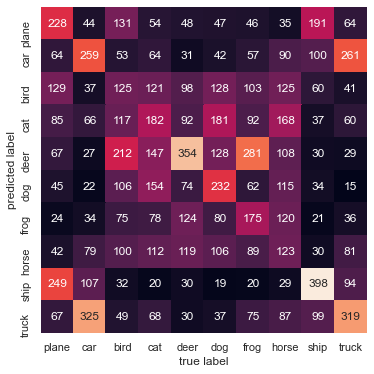

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fit,
                            target_names=classes))

precision    recall  f1-score   support

       plane       0.26      0.23      0.24      1000
         car       0.25      0.26      0.26      1000
        bird       0.13      0.12      0.13      1000
         cat       0.17      0.18      0.17      1000
        deer       0.26      0.35      0.30      1000
         dog       0.27      0.23      0.25      1000
        frog       0.23      0.17      0.20      1000
       horse       0.14      0.12      0.13      1000
        ship       0.40      0.40      0.40      1000
       truck       0.28      0.32      0.30      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.24     10000
weighted avg       0.24      0.24      0.24     10000



I had very high hopes for the RBF kernel since it would be able to catch nonlinearly seperable classes, even classes that can completely surround a class, but the improvement of accuracy is really only marginal compared to the original first try.  I do not think this was worth the computing effort.

End Reflection:
I am sadded by the accuracy values that I ended up getting, and I now realize that maybe it's not the features to blame necessarily but the validation set.  The validation splitting came as a convenience to me from a StackOverflow question.  I realize that I should have put more thought into how my validation set was programmed.  Maybe my hyper parameters were not approximated well by the validation sets.  Or maybe the PCA reduction was not approximated well by the dataset.  I will have to consider this issue when we move on to CNN.